In [1]:
# Code from #10.Lec
# https://colab.research.google.com/github/heartcored98/Standalone-DeepLearning/blob/master/Lec2/Assignment1_pytorch_MNIST_MLP.ipynb
!pip install -q torch torchvision
import torch
print(torch.__version__)

1.9.0+cu102


In [2]:
!nvidia-smi

Fri Sep  3 09:21:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn

batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

50000 10000 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


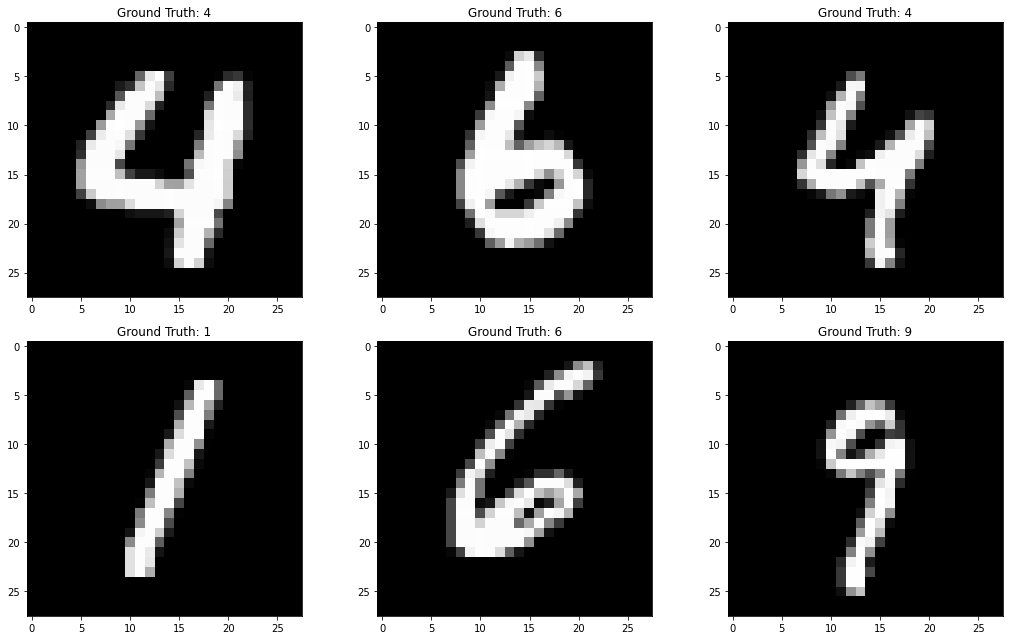

In [4]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

In [5]:
# Hypothesis Define(Model Define)
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

# class MLPModel(nn.Module):
#   def __init__(self, hidden_unit, hidden_layer):
#     super(MLPModel, self).__init__()
#     self.linear1 = nn.Linear(in_feature=784, out_feature=10, bias=True)
#     self.linear2 = nn.Linear(in_feature=hidden_unit, out_features=10, bias=True)
#     self.relu = nn.ReLU()
#     self.hidden_layer = hidden_layer

#   def forward(self, x):
#     x = self.linear1(x)
#     return x

In [6]:
# Cost Function
cls_loss = nn.CrossEntropyLoss()

In [12]:
print(torch.cuda.is_available())        # False가 뜨면 마음이 아픔... GPU를 사거나 다시 GPU 셋팅을 하거나...
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

True


In [29]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import time

# Construct Model
model = LinearModel()
model.to(device)                        # model을 GPU로 보냄
# model = MLPModel(784,10)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# Construct Optimizer
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
    ts = time.time()

    # Train
    train_loss = 0
    model.train() 
    optimizer.zero_grad() 
    
    for input_X, true_y in train_loader:
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)

        input_X = input_X.to(device)        # RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument mat1 in method wrapper_addmm)
        true_y = true_y.to(device)          # model이 GPU에 있으므로 parameter도 GPU로 보냄    
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        # train_loss += loss.detach().numpy()           # detach(): gradient를 다 날려줌    # TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
        # train_loss += loss.item().numpy()             # AttributeError: 'float' object has no attribute 'numpy', item()을 사용하면 numpy()도 필요 없음
        train_loss += loss.item()                       # item(): GPU에 loss가 저장되어 있는데 계산하려면 CPU로 다시 옮긴후 계산되어야함.
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # Validation
    val_loss = 0
    model.eval()
    optimizer.zero_grad()
    
    for input_X, true_y in val_loader:
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)

        input_X = input_X.to(device)
        true_y = true_y.to(device)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    list_val_loss.append(val_loss)


    # Evaluation
    correct = 0
    model.eval()
    optimizer.zero_grad()

    for input_X, true_y in test_loader:
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)

        input_X = input_X.to(device)
        true_y = true_y.to(device)
        pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
        correct += pred_y.eq(true_y).sum()

    acc = correct.item() / len(test_loader.dataset)    # TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
    list_acc.append(acc)
    list_acc_epoch.append(i)

    te = time.time()
    
    print('Epoch: {}\tTrain Loss: {}\tVal Loss: {}\tTest Acc: {}\tTime: {:3.3f}%'.format(i, train_loss, val_loss, acc*100, te-ts))

Number of 7850 parameters
Epoch: 0	Train Loss: 1.5250080406970685	Val Loss: 2.359654292275634	Test Acc: 89.31	Time: 14.743%
Epoch: 1	Train Loss: 1.7652943100008514	Val Loss: 1.9620992563947846	Test Acc: 87.37	Time: 14.734%
Epoch: 2	Train Loss: 1.4670332113037938	Val Loss: 2.0105045905596093	Test Acc: 88.4	Time: 14.779%
Epoch: 3	Train Loss: 1.3351739456738962	Val Loss: 2.1299653211726417	Test Acc: 86.37	Time: 14.800%
Epoch: 4	Train Loss: 1.3535921460069964	Val Loss: 2.061428994317598	Test Acc: 87.87	Time: 14.556%
Epoch: 5	Train Loss: 1.4940468293169271	Val Loss: 2.3748487558545945	Test Acc: 85.26	Time: 14.820%
Epoch: 6	Train Loss: 1.4746576890997265	Val Loss: 2.195696621001521	Test Acc: 87.35000000000001	Time: 14.725%
Epoch: 7	Train Loss: 1.5691606408494818	Val Loss: 2.7352995344355135	Test Acc: 85.11	Time: 14.772%
Epoch: 8	Train Loss: 1.8865989622710002	Val Loss: 3.1243975479391555	Test Acc: 85.57000000000001	Time: 14.776%
Epoch: 9	Train Loss: 1.9468867409869532	Val Loss: 2.69305646419

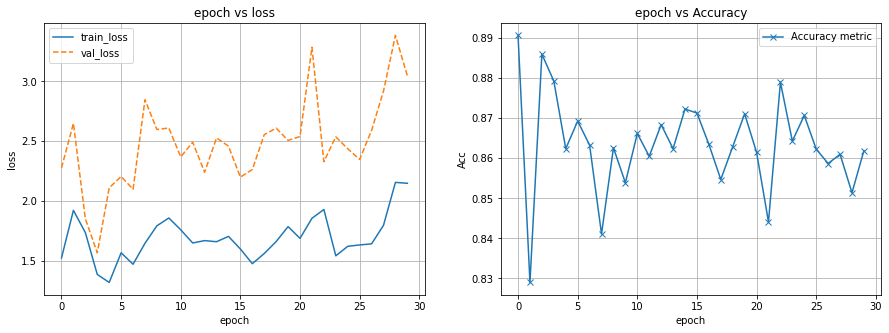

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()